In [1]:
import sys
sys.path.insert(0, '/Users/tijl/Dropbox/filmrecommender/qmdb')
from qmdb.database.database import MySQLDatabase
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score, r2_score
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
from sklearn.preprocessing import Imputer
import arrow
from scipy.stats import weibull_min

pd.set_option("display.max_rows",500)
pd.set_option("display.max_columns",100)

## Load the data

In [2]:
db = MySQLDatabase()

Loading movies...
Loading people...
Loading genres...
Loading countries...
Loading languages...
Loading keywords...
Loading taglines...
Loading vote details...
Loading ratings...
Creating Movie objects...


In [3]:
def ifnull(var, val):
    if isinstance(var, arrow.Arrow):
        return var
    if var is None or np.isnan(var):
        return val
    return var

In [4]:
movies = pd.DataFrame([db.movie_to_dict_movies(db.movies[crit_id]) for crit_id in db.movies])
movies['release_date'] = movies.apply(lambda r: ifnull(r['dutch_release_date'], 
    ifnull(r['original_release_date'], arrow.get(str(ifnull(r['imdb_year'],
    ifnull(r['year'], 1900))) + '-01-01'))), axis=1)
movies['years_since_release'] = movies['release_date'].apply(lambda r: (arrow.now() - r).days / 365.25)

In [5]:
cols = ['crit_id', 'imdbid', 'title', 'year', 'crit_rating', 'crit_votes', 'imdb_rating',
        'imdb_votes', 'kind', 'metacritic_score', 'runtime', 'years_since_release']
movies = movies[cols].set_index('crit_id')
print("{} movies in this dataframe.".format(len(movies)))
movies.head()

22821 movies in this dataframe.


,imdbid,title,year,crit_rating,crit_votes,imdb_rating,imdb_votes,kind,metacritic_score,runtime,years_since_release
crit_id,,,,,,,,,,,
1,391304.0,A Lot Like Love,2005,4.41,830,6.6,61925.0,movie,48.0,107.0,12.777550
3,212720.0,A.I. Artificial Intelligence,2001,5.24,11674,7.1,261741.0,movie,65.0,146.0,16.438056
4,267248.0,Abandon,2002,2.73,143,4.9,8360.0,movie,36.0,99.0,14.718686
5,281534.0,ABC Africa,2001,5.46,79,7.0,601.0,movie,73.0,83.0,16.128679
7,168446.0,Aberdeen,2000,6.55,67,7.2,2781.0,movie,78.0,113.0,16.501027


### Load my ratings

In [6]:
ratings = pd.DataFrame([{'crit_id': db.movies[crit_id].crit_id, 'myrating': db.movies[crit_id].crit_myratings.get('tijl')}
                           for crit_id in db.movies]).set_index('crit_id')
print("{} movies in this dataframe.".format(len(ratings)))
ratings.head()

AttributeError: 'Movie' object has no attribute 'crit_myratings'

In [ ]:
psis = pd.DataFrame([{'crit_id': db.movies[crit_id].crit_id, 'psi': db.movies[crit_id].crit_mypsis.get('tijl')}
                      for crit_id in db.movies]).set_index('crit_id')
print("{} movies in this dataframe.".format(len(psis)))
psis.head()

In [7]:
genres = pd.DataFrame([{'crit_id': db.movies[crit_id].crit_id, 'genres': db.movies[crit_id].genres}
                           for crit_id in db.movies]).set_index('crit_id')
print("{} movies in this dataframe.".format(len(genres)))
genres.head()

22821 movies in this dataframe.


,genres
crit_id,
1,"[Comedy, Drama, Romance]"
3,"[Adventure, Drama, Sci-Fi]"
4,"[Drama, Music, Mystery, Romance, Thriller]"
5,[Documentary]
7,[Drama]


### Combine everything

In [164]:
movies = pd.concat([movies, ratings, psis, genres], axis=1, join='outer')
movies['rated'] = movies['myrating'].apply(lambda x: 1 if x > 0 else 0)
print("{} movies in this dataframe.".format(len(movies)))
movies.head()

22717 movies in this dataframe.


,imdbid,title,year,crit_rating,crit_votes,imdb_rating,imdb_votes,kind,metacritic_score,runtime,years_since_release,myrating,psi,genres,rated
crit_id,,,,,,,,,,,,,,,
1,391304.0,A Lot Like Love,2005,4.41,829,6.6,61925.0,movie,48.0,107.0,12.763860,NaN,55.0,"[Comedy, Drama, Romance]",0
3,212720.0,A.I. Artificial Intelligence,2001,5.23,11667,7.1,261180.0,movie,65.0,146.0,16.424367,55.0,61.0,"[Adventure, Drama, Sci-Fi]",1
4,267248.0,Abandon,2002,2.73,143,4.9,8360.0,movie,36.0,99.0,16.180698,NaN,12.0,"[Drama, Music, Mystery, Romance, Thriller]",0
5,281534.0,ABC Africa,2001,5.46,79,7.0,601.0,movie,73.0,83.0,17.180014,NaN,NaN,[Documentary],0
7,168446.0,Aberdeen,2000,6.55,67,7.2,2781.0,movie,78.0,113.0,18.182067,NaN,NaN,[Drama],0


Only use movies with an imdbid.

In [165]:
movies = movies[movies['imdbid'] > 0]
print("{} movies in this dataframe.".format(len(movies)))

22630 movies in this dataframe.


## Split into training and test sets

In [166]:
movies_train, movies_test = train_test_split(movies, test_size=0.33, random_state=42)
print("{} movies in the training set.".format(len(movies_train)))
print("{} movies in the test set.".format(len(movies_test)))

15162 movies in the training set.
7468 movies in the test set.


### One-hot-encode some variables

In [167]:
def movie_kind_to_dict(kind):
    if isinstance(kind, str):
        return {'kind_' + kind.replace(" ", "_").lower(): 1}
    else:
        return {}
    
def movie_genres_to_dict(genres):
    if isinstance(genres, list):
        return {'genre_' + genre.replace(" ", "_").lower(): 1 for genre in genres}
    else:
        return {}

In [168]:
v = DictVectorizer(sparse=False)
D_train = [movie_kind_to_dict(movie['kind']) for i, movie in movies_train.iterrows()]
D_test = [movie_kind_to_dict(movie['kind']) for i, movie in movies_test.iterrows()]
X_train = v.fit_transform(D_train)
X_test = v.transform(D_test)
ohe_kind_train = pd.DataFrame(X_train, columns=v.feature_names_, index=movies_train.index)
ohe_kind_test = pd.DataFrame(X_test, columns=v.feature_names_, index=movies_test.index)
ohe_kind_train.head()

,kind_episode,kind_movie,kind_tv_mini_series,kind_tv_movie,kind_tv_series,kind_tv_short,kind_video_movie
crit_id,,,,,,,
137176,0.0,0.0,0.0,1.0,0.0,0.0,0.0
96632,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2610,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3842,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7306,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [169]:
v = DictVectorizer(sparse=False)
D_train = [movie_genres_to_dict(movie['genres']) for i, movie in movies_train.iterrows()]
D_test = [movie_genres_to_dict(movie['genres']) for i, movie in movies_test.iterrows()]
X_train = v.fit_transform(D_train)
X_test = v.transform(D_test)
ohe_genre_train = pd.DataFrame(X_train, columns=v.feature_names_, index=movies_train.index)
ohe_genre_test = pd.DataFrame(X_test, columns=v.feature_names_, index=movies_test.index)
ohe_genre_train.head()

,genre_action,genre_adult,genre_adventure,genre_animation,genre_biography,genre_comedy,genre_crime,genre_documentary,genre_drama,genre_family,...,genre_news,genre_reality-tv,genre_romance,genre_sci-fi,genre_short,genre_sport,genre_talk-show,genre_thriller,genre_war,genre_western
crit_id,,,,,,,,,,,,,,,,,,,,,
137176,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96632,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2610,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3842,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7306,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [170]:
movies_train = pd.concat([movies_train, ohe_kind_train, ohe_genre_train], axis=1, join='outer')
movies_test = pd.concat([movies_test, ohe_kind_test, ohe_genre_test], axis=1, join='outer')
print("{} movies in this dataframe.".format(len(movies)))
movies = movies_train.append(movies_test)
movies.head()

22630 movies in this dataframe.


,imdbid,title,year,crit_rating,crit_votes,imdb_rating,imdb_votes,kind,metacritic_score,runtime,...,genre_news,genre_reality-tv,genre_romance,genre_sci-fi,genre_short,genre_sport,genre_talk-show,genre_thriller,genre_war,genre_western
crit_id,,,,,,,,,,,,,,,,,,,,,
137176,7136060.0,Ratburger,2017,NaN,0,5.7,218.0,tv movie,NaN,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96632,2870756.0,Magic in the Moonlight,2014,4.62,717,6.6,55088.0,movie,54.0,97.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2610,163187.0,Runaway Bride,1999,3.07,3263,5.5,81738.0,movie,39.0,116.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3842,381392.0,Ma Mère,2004,3.60,181,5.1,5444.0,movie,35.0,110.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7306,74483.0,The Enforcer,1976,5.27,577,6.8,35349.0,movie,NaN,96.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Rating model

In [203]:
rated_movies_train = movies_train[movies_train['rated'] == 1]
rated_movies_test = movies_test[movies_test['rated'] == 1]
cols_to_use = [col for col in rated_movies_train.columns 
               if col not in ['imdbid', 'crit_id', 'title', 'kind', 'myrating', 'rated', 'genres', 'year']]
X_train = np.array(rated_movies_train[cols_to_use])
X_test = np.array(rated_movies_test[cols_to_use])
y_train = np.array(rated_movies_train['myrating'])
y_test = np.array(rated_movies_test['myrating'])

### Train model

In [204]:
%%time
pipe = Pipeline([("imputer", Imputer(missing_values="NaN",
                                     strategy="mean",
                                     axis=0)),
                  ("forest", RandomForestRegressor())])

param_grid = [{'imputer': [Imputer(missing_values="NaN",
                            strategy="mean",
                            axis=0)]},
              {'forest': [RandomForestRegressor()],
               'forest__max_features': ['auto', 'sqrt'],
               'forest__max_depth': [5, 10, 20],
               'forest__n_estimators': [100, 200, 500]}] # 

grid = GridSearchCV(pipe, cv=10, n_jobs=-1, param_grid=param_grid,
                    scoring='neg_mean_squared_error', return_train_score=True, verbose=1)
grid.fit(X_train, y_train)
print("Cross-validation RMSE: {:.3f}".format(np.sqrt(-grid.best_score_)))
estimator = grid.best_estimator_
y_pred = estimator.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_r2 = np.sqrt(r2_score(y_test, y_pred))
print("            Test RMSE: {:.3f}".format(test_rmse))
print("            Test R^2: {:.3f}".format(test_r2))
print("\nBest model:")
print("  max_features: {}".format(grid.best_params_['forest__max_features']))
print("  max_depth: {}".format(grid.best_params_['forest__max_depth']))
print("  n_estimators: {}\n".format(grid.best_params_['forest__n_estimators']))

Fitting 10 folds for each of 19 candidates, totalling 190 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:   45.3s finished


Cross-validation RMSE: 12.908
            Test RMSE: 12.544
            Test R^2: 0.720

Best model:
  max_features: sqrt
  max_depth: 20
  n_estimators: 500

CPU times: user 1.33 s, sys: 122 ms, total: 1.45 s
Wall time: 46.5 s


In [205]:
X_train_test = np.concatenate((X_train, X_test))
y_train_test = np.concatenate((y_train, y_test))
estimator.fit(X_train_test, y_train_test)
feature_importances = pd.DataFrame(dict(zip(cols_to_use, estimator.named_steps['forest'].feature_importances_)), 
                                   index=['feature_importance'])\
                        .T.sort_values(by='feature_importance', ascending=False)
feature_importances.head(10)

,feature_importance
psi,0.183182
crit_rating,0.160338
imdb_rating,0.127607
metacritic_score,0.082447
years_since_release,0.082347
imdb_votes,0.077966
crit_votes,0.063485
runtime,0.061170
genre_drama,0.021293
genre_comedy,0.016953


In [206]:
X = np.array(movies[cols_to_use])
rating_preds = pd.DataFrame([{'title': tuple[0], 'year': tuple[1], 'pred_rating': tuple[2]}
  for tuple in zip(list(movies['title']), list(movies['year']), list(estimator.predict(X)))])
rating_preds = rating_preds.set_index(pd.Index(list(movies_train.index) + list(movies_test.index)))
rating_preds = rating_preds.sort_values(by='pred_rating', ascending=False)
rating_preds.head(10)

,pred_rating,title,year
1840,94.608000,The Lord of the Rings: The Fellowship of the Ring,2001
1841,94.450000,The Lord of the Rings: The Return of the King,2003
2740,93.676211,The Shawshank Redemption,1994
2645,93.391500,Saving Private Ryan,1998
2902,91.980667,Star Wars: Episode IV - A New Hope,1977
2463,91.974000,Pulp Fiction,1994
2768,91.432211,The Silence of the Lambs,1991
962,90.832667,Star Wars: Episode V - The Empire Strikes Back,1980
1842,90.774000,The Lord of the Rings: The Two Towers,2002
109108,90.588562,Breaking Bad,2008


### Seen Model

## Split into training, validation and test sets

In [207]:
X_train = np.array(movies_train[cols_to_use])
X_test = np.array(movies_test[cols_to_use])
y_train = np.array(movies_train['rated'])
y_test = np.array(movies_test['rated'])

In [208]:
%%time
pipe = Pipeline([("imputer", Imputer(missing_values="NaN",
                                     strategy="mean",
                                     axis=0)),
                  ("forest", RandomForestClassifier())])

param_grid = [{'imputer': [Imputer(missing_values="NaN",
                            strategy="mean",
                            axis=0)]},
              {'forest': [RandomForestClassifier()],
               'forest__max_features': ['auto', 'sqrt'],
               'forest__max_depth': [5, 10, 20],
               'forest__n_estimators': [100, 200, 500]}]

grid = GridSearchCV(pipe, cv=10, n_jobs=-1, param_grid=param_grid, scoring='roc_auc', 
                    return_train_score=True, verbose=1)
grid.fit(X_train, y_train)
print("Cross-validation AUC: {:.3f}".format(grid.best_score_))
estimator = grid.best_estimator_
y_pred = estimator.predict_proba(X_test)[:,1]
test_auc = roc_auc_score(y_test, y_pred)
print("            Test AUC: {:.3f}".format(test_auc))
print("\nBest model:")
print("  max_features: {}".format(grid.best_params_['forest__max_features']))
print("  max_depth: {}".format(grid.best_params_['forest__max_depth']))
print("  n_estimators: {}".format(grid.best_params_['forest__n_estimators']))

Fitting 10 folds for each of 19 candidates, totalling 190 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:  2.9min finished


Cross-validation AUC: 0.968
            Test AUC: 0.982

Best model:
  max_features: auto
  max_depth: 20
  n_estimators: 500
CPU times: user 7.57 s, sys: 256 ms, total: 7.82 s
Wall time: 3min 1s


In [209]:
X_train_test = np.concatenate((X_train, X_test))
y_train_test = np.concatenate((y_train, y_test))
estimator.fit(X_train_test, y_train_test)
feature_importances = pd.DataFrame(dict(zip(cols_to_use, estimator.named_steps['forest'].feature_importances_)), 
                                   index=['feature_importance'])\
                        .T.sort_values(by='feature_importance', ascending=False)
feature_importances.head(10)

,feature_importance
crit_votes,0.256708
imdb_votes,0.220744
metacritic_score,0.080923
years_since_release,0.071855
crit_rating,0.070675
psi,0.068995
imdb_rating,0.067240
runtime,0.050724
genre_adventure,0.008543
genre_drama,0.008054


In [210]:
X = np.array(movies[cols_to_use])
seen_preds = pd.DataFrame([{'title': tuple[0], 'year': tuple[1], 'seen_probability': tuple[2]}
  for tuple in zip(list(movies['title']), list(movies['year']), list(estimator.predict_proba(X)[:,1]))])
seen_preds = seen_preds.set_index(pd.Index(list(movies_train.index) + list(movies_test.index)))
seen_preds = seen_preds.sort_values(by='seen_probability', ascending=False)
seen_preds.head(10)

,seen_probability,title,year
962,1.000000,Star Wars: Episode V - The Empire Strikes Back,1980
11177,1.000000,The Departed,2006
1352,1.000000,Heat,1995
1089,1.000000,Finding Nemo,2003
2902,1.000000,Star Wars: Episode IV - A New Hope,1977
2488,0.999983,Raiders of the Lost Ark,1981
4068,0.999970,Match Point,2005
2373,0.999958,The Pianist,2002
2109,0.999954,Mulholland Drive,2001
3492,0.999824,2001: A Space Odyssey,1968


## Combine results

In [488]:
def my_weibull(x, c=0.6, a=0.8, b=3):
    return np.real(1-weibull_min.cdf(x**a/b, c))

scored_movies = pd.concat([movies, seen_preds[['seen_probability']], rating_preds[['pred_rating']]], 
                          axis=1, join='outer')
scored_movies['pred_seeit'] = scored_movies\
    .apply(lambda row: np.power(row['seen_probability']*my_weibull(row['years_since_release'])**3, 1/4), axis=1)
scored_movies['random'] = np.random.rand(len(scored_movies))
scored_movies['show'] = scored_movies.apply(lambda row: 1 if row['pred_seeit'] >= row['random'] else 0, axis=1)
scored_movies['score'] = scored_movies.apply(lambda row: np.power(row['pred_seeit'] * (row['pred_rating']/100)**3, 1/4)*100, axis=1)
movies_to_see = scored_movies[(scored_movies['rated'] == 0) & 
                               (scored_movies['show'] == 1) &
                              (scored_movies['pred_rating'] >= 50) &
#                               (scored_movies['kind'].isin(['tv series', 'tv mini series'])) &
                              (scored_movies['kind'] == 'movie') &
                              (scored_movies['genre_short'] == 0)]\
    .sort_values(by='score', ascending=False)
cols_to_show = ['title', 'year', 'pred_seeit', 'pred_rating', 'crit_rating',
               'imdb_rating', 'imdb_votes', 'metacritic_score', 'runtime', 'psi', 'genres','score']
movies_to_see[cols_to_show].head(500)

,title,year,pred_seeit,pred_rating,crit_rating,imdb_rating,imdb_votes,metacritic_score,runtime,psi,genres,score
129900,"Three Billboards Outside Ebbing, Missouri",2017,0.595811,79.004440,7.49,8.3,133165.0,88.0,115.0,82.0,"[Crime, Drama]",73.623373
125503,Call Me by Your Name,2017,0.571542,78.689106,7.42,8.2,61565.0,93.0,132.0,80.0,"[Drama, Romance]",72.643701
132766,Lady Bird,2017,0.681202,70.960950,6.97,7.7,64852.0,94.0,94.0,68.0,"[Comedy, Drama]",70.239833
133042,Blade Runner 2049,2017,0.499834,77.495308,7.69,8.2,249604.0,81.0,164.0,79.0,"[Drama, Mystery, Sci-Fi, Thriller]",69.448528
135607,Coco,2017,0.544876,71.879133,7.51,8.6,108309.0,81.0,105.0,78.0,"[Adventure, Animation, Comedy, Family, Fantasy...",67.069743
119346,The Handmaiden,2016,0.416178,77.892504,7.66,8.1,55164.0,84.0,144.0,82.0,"[Crime, Drama, Mystery, Romance, Thriller]",66.594967
5964,The Hidden Fortress,1958,0.381917,76.675303,7.52,8.1,27012.0,NaN,139.0,75.0,"[Adventure, Drama]",64.414540
119388,The Salesman,2016,0.371888,77.273821,7.29,7.9,32701.0,85.0,124.0,79.0,"[Drama, Thriller]",64.361674
129005,The Disaster Artist,2017,0.528975,68.621244,6.49,7.7,51005.0,76.0,104.0,69.0,"[Biography, Comedy, Drama]",64.298777
127695,Logan,2017,0.493606,70.096872,6.87,8.1,453428.0,77.0,137.0,70.0,"[Action, Drama, Sci-Fi, Thriller]",64.212440


In [493]:
scored_movies.columns

Index(['imdbid', 'title', 'year', 'crit_rating', 'crit_votes', 'imdb_rating',
       'imdb_votes', 'kind', 'metacritic_score', 'runtime',
       'years_since_release', 'myrating', 'psi', 'genres', 'rated',
       'kind_episode', 'kind_movie', 'kind_tv_mini_series', 'kind_tv_movie',
       'kind_tv_series', 'kind_tv_short', 'kind_video_movie', 'genre_action',
       'genre_adult', 'genre_adventure', 'genre_animation', 'genre_biography',
       'genre_comedy', 'genre_crime', 'genre_documentary', 'genre_drama',
       'genre_family', 'genre_fantasy', 'genre_film-noir', 'genre_game-show',
       'genre_history', 'genre_horror', 'genre_music', 'genre_musical',
       'genre_mystery', 'genre_news', 'genre_reality-tv', 'genre_romance',
       'genre_sci-fi', 'genre_short', 'genre_sport', 'genre_talk-show',
       'genre_thriller', 'genre_war', 'genre_western', 'seen_probability',
       'pred_rating', 'pred_seeit', 'random', 'show', 'score'],
      dtype='object')

In [495]:
movie_dicts = [{'crit_id': i, 
  'title': row['title'], 
  'seen_probability': row['seen_probability'],
  'pred_rating': row['pred_rating'],
  'pred_seeit': row['pred_seeit'],
  'pred_score': row['score']} for i, row in scored_movies.iterrows()]

## Some random stuff...

In [110]:
a = sorted(np.random.weibull(1,1000)*1)
print("p05: {:.1f}\np50: {:.1f}\np95: {:.1f}"
      .format(10**np.percentile(a, 10)-1, 10**np.percentile(a, 50)-1, 10**np.percentile(a, 90)-1))

p05: 0.3
p50: 3.7
p95: 186.1


In [310]:
a = (10**np.random.weibull(1.1, len(scored_movies))-1)*0.8
print("p05: {:.1f}\np50: {:.1f}\np95: {:.1f}"
      .format(np.percentile(a, 10), np.percentile(a, 50), np.percentile(a, 90)))

p05: 0.3
p50: 3.4
p95: 114.8


  3 months: 0.7665063354864805
  5 years : 0.32626731895049754
100 years : 0.008936005383860302


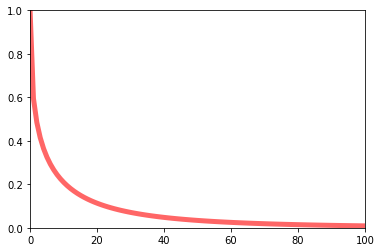

In [445]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
c = 0.6
mean, var, skew, kurt = weibull_min.stats(c, moments='mvsk')
x = np.linspace(0, 100, 100)

def my_weibull(x, c=0.6, a=0.8, b=3):
    return 1-weibull_min.cdf(x**a/b, c)

ax.plot(x, my_weibull(x, c), 'r-', lw=5, alpha=0.6, label='weibull_min pdf')
ax.set_ylim(0,1)
ax.set_xlim(0,100)
print("  3 months: {}".format(my_weibull(0.25, c)))
# print("  6 months: {}".format(my_weibull(0.5, c)))
# print("  1 year  : {}".format(my_weibull(1, c)))
# print("  2 years : {}".format(my_weibull(2, c)))
print("  5 years : {}".format(my_weibull(5, c)))
# print(" 10 years : {}".format(my_weibull(10, c)))
# print(" 20 years : {}".format(my_weibull(20, c)))
# print(" 50 years : {}".format(my_weibull(50, c)))
print("100 years : {}".format(my_weibull(100, c)))
plt.show()

In [323]:
weibull_min.cdf(10, 1)

0.99995460007023751

In [325]:
np.log10(100)

2.0